In [282]:
import numpy as np
import pandas as pd
import datetime as dt
import bz2
import json
from tld import get_tld
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
import math
from collections import Counter
from operator import itemgetter
import re
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

nltk.download()
nltk.download('stopwords')
nltk.download('punkt')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lisalaurent/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lisalaurent/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from Data_clean_functions import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lisalaurent/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lisalaurent/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [198]:
#Settings for the plots 
sns.set_style("ticks")
colors= sns.color_palette('colorblind')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=13)
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.minor.size'] = 6

sns.set_style("darkgrid", {'axes.grid' : False, 'ytick.left': True, 'xtick.bottom': True})

In [3]:
DATA_PATH = './data/'
FILE2016 = DATA_PATH + 'quotes-2016.json.bz2'
CLEAN2016 = DATA_PATH + 'clean-quotes-2016.json.bz2'
#PATH_OUT = DATA_PATH + 'clean-quotes.json.bz2'

In [4]:
Wikidata_speakers = pd.read_parquet(DATA_PATH + 'speaker_attributes.parquet')
Wikidata_speakers

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055976,[Barker Howard],None,[Q30],[Q6581097],1397399351,None,None,[Q82955],None,None,Q106406560,Barker B. Howard,None,item,None
9055977,[Charles Macomber],None,[Q30],[Q6581097],1397399471,None,None,[Q82955],None,None,Q106406571,Charles H. Macomber,None,item,None
9055978,None,[+1848-04-01T00:00:00Z],None,[Q6581072],1397399751,None,None,None,None,None,Q106406588,Dina David,None,item,None
9055979,None,[+1899-03-18T00:00:00Z],None,[Q6581072],1397399799,None,None,None,None,None,Q106406593,Irma Dexinger,None,item,None


In [71]:
# Open pickled file
chunks_all = pd.DataFrame(columns=['quoteID', 'quotation', 'speaker', 'qids', 'date', 'numOccurrences',
       'probas', 'urls', 'phase', 'gender', 'citizenship', 'Description',
       'sitenames', 'domain', 'tags'])
chunk_nbr = 0
n_chunks=2000
with open(CLEAN2016, 'rb') as d_file:
    while (chunk_nbr < n_chunks):
        chunk = pickle.load(d_file)
        chunks_all = chunks_all.append(chunk)
        chunk_nbr+=1
        print(chunk_nbr)
        # Need to load m times if you want to get to the m^th file

UnpicklingError: could not find MARK

In [73]:
df_base = pd.read_json(CLEAN2016, orient='columns', compression='bz2')
df_base

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,gender,citizenship,Description,sitenames,domain,tags
0,2016-12-26-000040,[ ] and Chris [ Jones ] were in there a lot an...,Andy Reid,Q2622812,2016-12-26 20:05:00,1,"[Andy Reid, 0.9432]",[http://www.kcchiefs.com/news/article-2/How-a-...,E,Male,United States of America,sovereign state in North America,[kcchiefs],[com],[[]]
1,2016-07-31-000006,[ And ] I don't know if we have enough time to...,Mike Howe,Q6847325,2016-07-31 08:22:12,2,"[Mike Howe, 0.7118]",[http://www.peninsuladailynews.com/apps/pbcs.d...,E,Male,United States of America,sovereign state in North America,"[peninsuladailynews, peninsuladailynews]","[com, com]","[[], []]"
2,2016-07-11-000226,[ I ] mmigration has been and continues to be ...,Hillary Clinton,Q6294,2016-07-11 17:26:06,1,"[Hillary Clinton, 0.9025]",[http://www.breitbart.com/tech/2016/07/11/hill...,E,Female,United States of America,sovereign state in North America,[breitbart],[com],[[]]
3,2016-05-26-000371,[ It is ] the process of understanding what ki...,Bruce Maxwell,Q26129591,2016-05-26 15:21:37,1,"[Bruce Maxwell, 0.8178]",[http://www.scout.com/mlb/athletics/story/1673...,E,Male,None,None,[scout],[com],[[sport]]
4,2016-02-12-000118,[ It ] would give us more flexibility in terms...,Bob McDonald,Q41948618,2016-02-12 18:30:52,1,"[Bob McDonald, 0.9298]",[http://federalnewsradio.com/ses/2016/02/ses-m...,E,Male,None,None,[federalnewsradio],[com],[[]]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,2016-12-11-010250,Everybody who lives in Lemont has been affecte...,Sue Smith,Q15040075,2016-12-11 10:00:00,1,"[Sue Smith, 0.857]",[http://www.statecollege.com/news/local-news/d...,E,Female,United Kingdom,country in Western Europe,[statecollege],[com],[[]]
566,2016-05-26-022023,Everybody's been supportive (but) everybody's ...,Mike Pennel,Q17712918,2016-05-26 20:55:46,1,"[Mike Pennel, 0.551]",[http://www.scout.com/nfl/packers/story/167313...,E,Male,United States of America,sovereign state in North America,[scout],[com],[[]]
567,2016-07-18-019424,"Everyone has a right to voice their opinion, e...",Norman Kwong,Q119775,2016-07-18 14:05:38,1,"[Norman Kwong, 0.7824]",[http://nbcnews.com/news/asian-america/asian-a...,E,Male,Canada,sovereign state in North America,[nbcnews],[com],[[]]
568,2016-08-09-019117,Everyone has been so friendly and I cannot wai...,Guochuan Lai,Q27975214,2016-08-09 17:14:51,4,"[Guochuan Lai, 0.8836]",[http://expressandstar.com/sport/west-bromwich...,E,Male,People's Republic of China,sovereign state in East Asia,"[expressandstar, standard, standard, standard]","[com, co.uk, co.uk, co.uk]","[[sport], [sport, sport], [sport, sport], [spo..."


In [303]:
countries_to_continent = pd.read_csv(DATA_PATH+'Countries_to_continent.csv', sep=';')
countries_to_continent

,Continent,Country
0,Africa,Algeria
1,Africa,Angola
2,Africa,Benin
3,Africa,Botswana
4,Africa,Burkina
...,...,...
189,South America,Paraguay
190,South America,Peru
191,South America,Suriname
192,South America,Uruguay


## Age

In [5]:
Wikidata_speakers['date_of_birth'] = from_array_to_single_string(Wikidata_speakers['date_of_birth'])
Wikidata_speakers['date_of_birth'] = Wikidata_speakers['date_of_birth'].replace(to_replace='[\+Z]',value='', 
                                                                                regex=True)#, inplace=True)
Wikidata_speakers['date_of_birth'] = pd.to_datetime(Wikidata_speakers['date_of_birth'], 
                                       format='%Y-%m-%dT%H:%M:%S', 
                                       errors='coerce')

In [69]:
Wikidata_speakers

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",1732-02-22,"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",1952-03-11,[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",1868-08-23,[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",1946-07-06,[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",NaT,[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055976,[Barker Howard],NaT,[Q30],[Q6581097],1397399351,None,None,[Q82955],None,None,Q106406560,Barker B. Howard,None,item,None
9055977,[Charles Macomber],NaT,[Q30],[Q6581097],1397399471,None,None,[Q82955],None,None,Q106406571,Charles H. Macomber,None,item,None
9055978,None,1848-04-01,None,[Q6581072],1397399751,None,None,None,None,None,Q106406588,Dina David,None,item,None
9055979,None,1899-03-18,None,[Q6581072],1397399799,None,None,None,None,None,Q106406593,Irma Dexinger,None,item,None


In [79]:
def compute_age(chunk):
    now = pd.to_datetime('now')
    age = (now.year - chunk.date_of_birth.dt.year) - ((now.month - chunk.date_of_birth.dt.month) < 0)
    chunk['age'] = age
    return chunk

In [80]:
Wikidata_age = compute_age(Wikidata_speakers)

In [81]:
Wikidata_age

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion,age
0,"[Washington, President Washington, G. Washingt...",1732-02-22,"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443],289.0
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",1952-03-11,[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None,69.0
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",1868-08-23,[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None,153.0
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",1946-07-06,[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]",75.0
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",NaT,[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055976,[Barker Howard],NaT,[Q30],[Q6581097],1397399351,None,None,[Q82955],None,None,Q106406560,Barker B. Howard,None,item,None,NaN
9055977,[Charles Macomber],NaT,[Q30],[Q6581097],1397399471,None,None,[Q82955],None,None,Q106406571,Charles H. Macomber,None,item,None,NaN
9055978,None,1848-04-01,None,[Q6581072],1397399751,None,None,None,None,None,Q106406588,Dina David,None,item,None,173.0
9055979,None,1899-03-18,None,[Q6581072],1397399799,None,None,None,None,None,Q106406593,Irma Dexinger,None,item,None,122.0


TODO: 
Compute the age in df_base (once date_of_birth is added in the merging process): df_base = compute_age(df_base)
Plot histogram of age per interval of 10 years
For the moment, keep only the speakers that have age<100 for analysis. Later on, we could think of analysing by epoch also

## Count male/female

### Number of quotes

In [274]:
gender_count = df_base.groupby(by=['gender'])['quoteID'].count().to_frame(name='count')
gender_count

,count
gender,
Female,106
Male,464


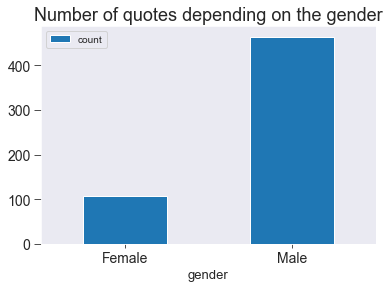

In [203]:
axs = gender_count.plot(kind='bar', title='Number of quotes depending on the gender', rot=0)

#### Statistical test

### Number of quotes per country

In [204]:
gender_citizenship_count = df_base.groupby(['gender', 'citizenship'])['quoteID'].count().to_frame(name='count')
gender_citizenship_count

count
gender citizenship                    
Female Australia                     7
       Canada                        5
       Cuba                          1
       France                        1
       Germany                       1
...                                ...
Male   United States of America    200
       Vatican City                  1
       Venezuela                     3
       Wales                         1
       Zimbabwe                      1

[69 rows x 1 columns]

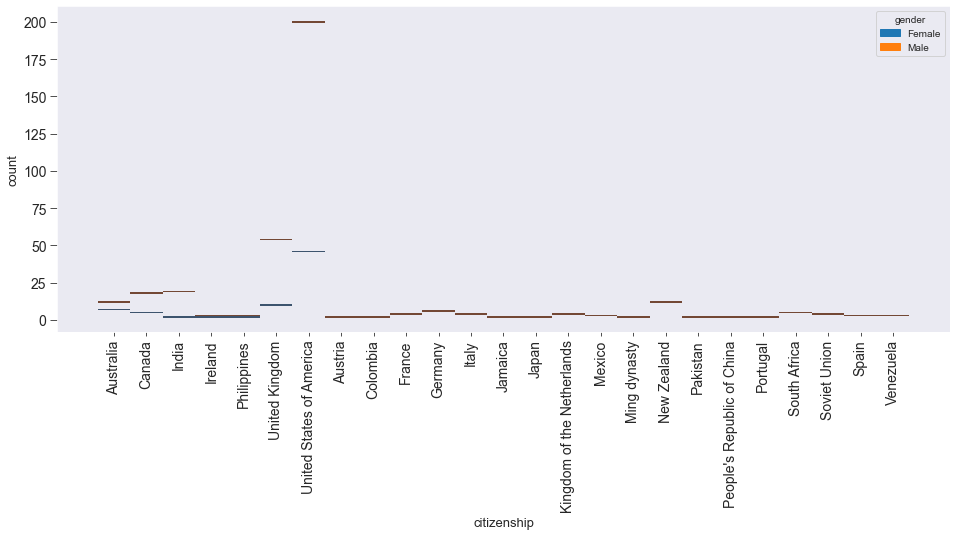

In [314]:
f = plt.figure(figsize=(16,6))
sns.histplot(data = gender_citizenship_count[gender_citizenship_count['count']>1], x="citizenship", y='count', element='bars', hue = "gender",
             multiple="dodge", shrink=.8, discrete=True, fill=True, binwidth=0.4)

#, thresh=1, palette=[colors[6], colors[-1]]) 
#axs.set_xticklabels(f.get_xticklabels(), rotation=0, horizontalalignment='right');
locs, labels = plt.xticks()
plt.setp(labels, rotation=90);

### Number of quotes per continent

In [304]:
gender_continent = pd.merge(df_base, countries_to_continent, left_on='citizenship', right_on='Country', copy=False)
gender_continent.drop('Country', axis=1)
gender_continent

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,gender,citizenship,Description,sitenames,domain,tags,Continent,Country
0,2016-12-26-000040,[ ] and Chris [ Jones ] were in there a lot an...,Andy Reid,Q2622812,2016-12-26 20:05:00,1,"[Andy Reid, 0.9432]",[http://www.kcchiefs.com/news/article-2/How-a-...,E,Male,United States of America,sovereign state in North America,[kcchiefs],[com],[[]],North America,United States of America
1,2016-07-31-000006,[ And ] I don't know if we have enough time to...,Mike Howe,Q6847325,2016-07-31 08:22:12,2,"[Mike Howe, 0.7118]",[http://www.peninsuladailynews.com/apps/pbcs.d...,E,Male,United States of America,sovereign state in North America,"[peninsuladailynews, peninsuladailynews]","[com, com]","[[], []]",North America,United States of America
2,2016-07-11-000226,[ I ] mmigration has been and continues to be ...,Hillary Clinton,Q6294,2016-07-11 17:26:06,1,"[Hillary Clinton, 0.9025]",[http://www.breitbart.com/tech/2016/07/11/hill...,E,Female,United States of America,sovereign state in North America,[breitbart],[com],[[]],North America,United States of America
3,2016-05-16-000278,[ Malia ] knows what she is going to do. They ...,Paul Bryant,Q2059029,2016-05-16 11:44:37,1,"[Paul Bryant, 0.9197]",[http://walb.com/story/31980641/some-colleges-...,E,Male,United States of America,sovereign state in North America,[walb],[com],[[]],North America,United States of America
4,2016-12-23-000368,[ Silver ] didn't have to come up there to the...,Stephon Marbury,Q319336,2016-12-23 14:03:51,3,"[Stephon Marbury, 0.721]",[http://www.nba.com/article/2016/12/23/morning...,E,Male,United States of America,sovereign state in North America,"[nba, nba, sportal]","[com, com, co.nz]","[[], [], []]",North America,United States of America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,2016-07-18-017410,don't win anything anymore.,Melania Trump,Q432473,2016-07-18 07:02:12,4,"[Melania Trump, 0.5245]",[http://armytimes.com/story/military/election/...,E,Female,Slovenia,country in Central Europe,"[armytimes, marinecorpstimes, militarytimes, n...","[com, com, com, com]","[[], [], [], []]",Europe,Slovenia
461,2016-12-05-019464,Especially here and Boston were the two teams ...,Al Horford,Q521931,2016-12-05 15:53:56,2,"[Al Horford, 0.6492]",[http://larrybrownsports.com/basketball/al-hor...,E,Male,Dominican Republic,island sovereign state in the Caribbean Sea,"[larrybrownsports, yardbarker]","[com, com]","[[], []]",North America,Dominican Republic
462,2016-07-23-011013,"Europe's current political leadership has failed,",Viktor Orban,Q57641,2016-07-23 00:00:00,69,"[Viktor Orban, 0.8245]",[http://thestar.com/news/world/2016/07/23/hung...,E,Male,Hungary,country in Central Europe,"[thestar, koin, wncn, wspa, wjtv, nytimes, wln...","[com, com, com, com, com, com, com, com, com, ...","[[], [], [], [], [], [], [], [], [], [politics...",Europe,Hungary
463,2016-08-10-019003,Even if I don't have my best day I can touch t...,Katinka Hosszu,Q667655,2016-08-10 17:35:06,2,"[Katinka Hosszu, 0.814]",[http://ph.sports.yahoo.com/news/rio-scrutiny-...,E,Female,Hungary,country in Central Europe,"[yahoo, breitbart]","[com, com]","[[sport, sport], [sport]]",Europe,Hungary


In [305]:
gender_continent_count = gender_continent.groupby(['gender', 'Continent'])['quoteID'].count().to_frame(name='count')
gender_continent_count

count
gender Continent           
Female Africa             1
       Asia               4
       Europe            18
       North America     52
       Oceania            8
       South America      1
Male   Africa             9
       Asia              29
       Europe            86
       North America    227
       Oceania           24
       South America      6

In [307]:
gender_citizenship_count['count'].sum()

484

In [306]:
gender_continent_count['count'].sum()

465

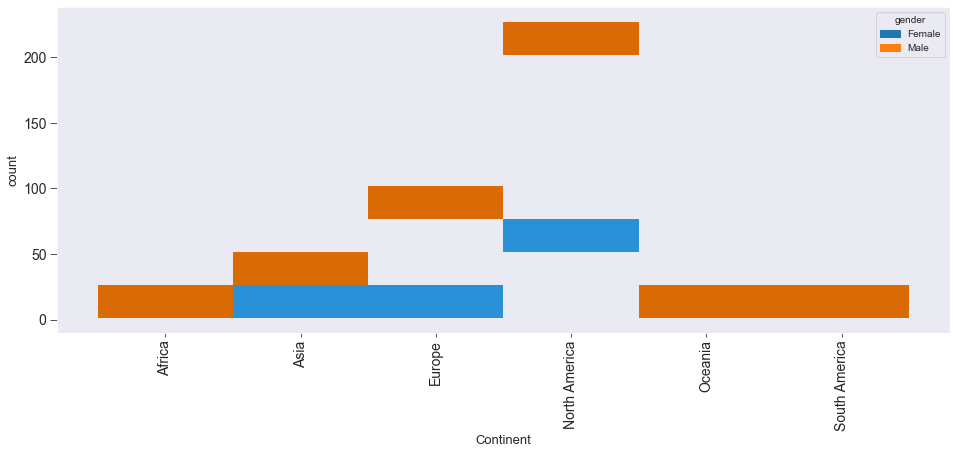

In [309]:
f = plt.figure(figsize=(16,6))
sns.histplot(data = gender_continent_count, x="Continent", element='bars', hue = "gender"
            , shrink=.5, multiple="dodge", y='count')#,
             #, discrete=True, fill=True)

#, thresh=1, palette=[colors[6], colors[-1]]) 
#axs.set_xticklabels(f.get_xticklabels(), rotation=0, horizontalalignment='right');
locs, labels = plt.xticks()
plt.setp(labels, rotation=90);